# Introduction

The GraphBLAS is an API for sparse matrix and vector operations.  This notebook acts as an introduction to the GraphBLAS and also tutorial on how work with graphs in Python using the pygraphblas library.

In [13]:
from itertools import product, repeat
from pygraphblas import Matrix, Vector, lib
from pygraphblas.semiring import min_plus_int64
from pygraphblas.binaryop import min_int64, Accum

from pygraphblas.demo.gviz import draw_graph, draw_layers
from operator import mod, mul, eq
from functools import reduce

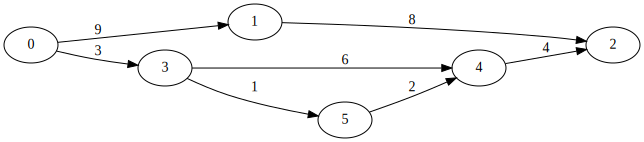

In [14]:
m = Matrix.from_lists(
    [0, 0, 1, 3, 3, 4, 5],
    [1, 3, 2, 4, 5, 2, 4],
    [9, 3, 8, 6, 1, 4, 2],)
draw_graph(m)

In [ ]:
def bfs(matrix, source):
    v = Vector.from_type(matrix.gb_type, matrix.nrows)


In [16]:
def shortest_path_length(matrix, start):
    v = Vector.from_type(matrix.gb_type, matrix.nrows)
    v[start] = 0

    with min_plus_int64, Accum(min_int64):
        for _ in range(matrix.nrows):
            w = Vector.dup(v)
            v @= matrix
            if w.iseq(v):
                break
        return v

shortest_path_length(m, 0).to_lists()

[[0, 1, 2, 3, 4, 5], [0, 9, 10, 3, 6, 4]]

[[0], [0]]